In [38]:
# Importamos las librerías que vamos a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [101]:
# Cargamos los datos que vamos a utilizar.
df_train = pd.read_csv(r'..\Data\processed\train-processed.csv')
df_val = pd.read_csv(r'..\Data\processed\val-processed.csv')

images_train = np.load(
    '../Data/processed/image_array100_train.npy', allow_pickle=True)
images_val = np.load(
    '../Data/processed/image_array100_val.npy', allow_pickle=True)


In [102]:
print(images_train.shape)
print(images_val.shape)

(6637, 100, 100, 3)
(6685, 100, 100, 3)


In [103]:
X = images_train
y_gender = df_train['Gender']
y_age_raw = df_train['Age']
# Normalizamos los datos de edad para obtener mejor convergencia
# 80 es el mayor dato de edad según el autor del set de datos.
y_age = y_age_raw / 80 

y_gender = np.array(y_gender)
y_age = np.array(y_age)

print('Dimensiones de X:', X.shape)
print('Dimensiones de y_gender:', y_gender.shape)
print('Dimensiones de y_age:', y_age.shape)

Dimensiones de X: (6637, 100, 100, 3)
Dimensiones de y_gender: (6637,)
Dimensiones de y_age: (6637,)


In [104]:
X_val = images_val
y_gender_val = df_val['Gender']
y_age_raw_val = df_val['Age']
y_age_val = y_age_raw_val / 80

y_gender_val = np.array(y_gender_val)
y_age_val = np.array(y_age_val)

print('Dimensiones de X:', X_val.shape)
print('Dimensiones de y_gender:', y_gender_val.shape)
print('Dimensiones de y_age:', y_age_val.shape)

Dimensiones de X: (6685, 100, 100, 3)
Dimensiones de y_gender: (6685,)
Dimensiones de y_age: (6685,)


In [105]:
print(y_age*80)
print(y_gender)

[29. 36. 46. ... 36. 37. 23.]
[0 1 0 ... 1 1 0]


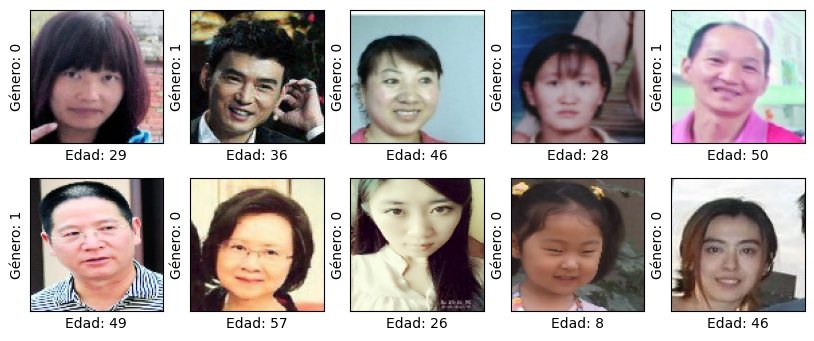

In [106]:
# Verificamos que todo esté correcto:
plt.figure(figsize=(10, 4))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i])
    plt.xlabel(f'Edad: {int(80*y_age[i])}')
    plt.ylabel(f'Género: {y_gender[i]}')
plt.show()


In [107]:
# Creamos nuestro modelo:
# Definición de la entrada
inputs = Input(shape=(100, 100, 3), name='input_1')

# Capas de convolución
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_1')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_1')(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu', name='conv2d_2')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_2')(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv2d_3')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_3')(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv2d_4')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2), name='max_pooling2d_4')(conv_4)

# Capa de aplanamiento
flatten = Flatten()(maxp_4)

# Capas totalmente conectadas
dense_1 = Dense(256, activation='relu', name='dense_1')(flatten)
dense_2 = Dense(256, activation='relu', name='dense_2')(flatten)

# Capas de dropout
dropout_1 = Dropout(0.3, name='dropout_1')(dense_1)
dropout_2 = Dropout(0.3, name='dropout_2')(dense_2)

# Capas de salida
output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

# Creación del modelo
model = Model(inputs=inputs, outputs=[output_1, output_2])

# Resumen del modelo
model.summary()

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy', 'mae'])

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 98, 98, 32)   896         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 49, 49, 32)  0           ['conv2d_1[0][0]']               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 47, 47, 64)   18496       ['max_pooling2d_1[0][0]'] 

In [112]:
ckpt_path = '../models/best_model.h5'


# Entrenamos al modelo:
history = model.fit(x=X, y={'gender_out': y_gender, 'age_out': y_age}, batch_size=32, 
                    epochs=7, validation_data=(X_val, {'gender_out': y_gender_val, 'age_out': y_age_val}), )

Epoch 1/7
208/208 [==============================] - 35s 170ms/step - loss: 0.3273 - gender_out_loss: 0.1899 - age_out_loss: 0.1374 - gender_out_accuracy: 0.9256 - gender_out_mae: 0.1146 - age_out_accuracy: 0.0023 - age_out_mae: 0.1374 - val_loss: 0.5015 - val_gender_out_loss: 0.3636 - val_age_out_loss: 0.1379 - val_gender_out_accuracy: 0.8567 - val_gender_out_mae: 0.1733 - val_age_out_accuracy: 0.0030 - val_age_out_mae: 0.1379
Epoch 2/7
208/208 [==============================] - 35s 168ms/step - loss: 0.2700 - gender_out_loss: 0.1386 - age_out_loss: 0.1314 - gender_out_accuracy: 0.9474 - gender_out_mae: 0.0853 - age_out_accuracy: 0.0029 - age_out_mae: 0.1314 - val_loss: 0.5289 - val_gender_out_loss: 0.3922 - val_age_out_loss: 0.1366 - val_gender_out_accuracy: 0.8616 - val_gender_out_mae: 0.1634 - val_age_out_accuracy: 0.0027 - val_age_out_mae: 0.1366
Epoch 3/7
208/208 [==============================] - 36s 175ms/step - loss: 0.2426 - gender_out_loss: 0.1154 - age_out_loss: 0.1272 - ge

In [113]:
model.save('../models/model-1-14epoch.h5')

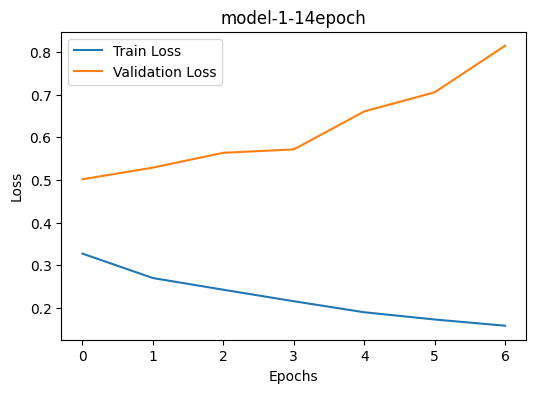

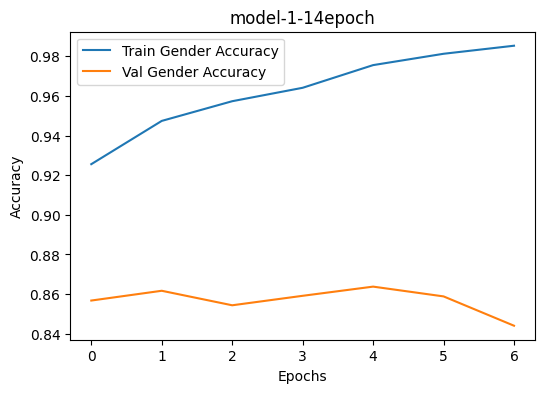

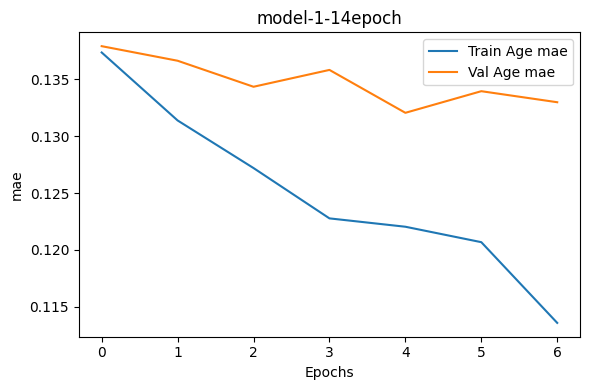

In [117]:
# Obtener las métricas del historial
train_loss = history.history['loss']
train_gender_loss = history.history['gender_out_loss']
train_age_loss = history.history['age_out_loss']
train_gender_accuracy = history.history['gender_out_accuracy']
train_age_mae = history.history['age_out_mae']

val_loss = history.history['val_loss']
val_gender_loss = history.history['val_gender_out_loss']
val_age_loss = history.history['val_age_out_loss']
val_gender_accuracy = history.history['val_gender_out_accuracy']
val_age_mae = history.history['val_age_out_mae']

titulo = 'model-1-14epoch'

# Graficar las curvas de pérdida
plt.figure(figsize=(6, 4))
plt.title(titulo)

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Graficar las curvas de precisión
plt.figure(figsize=(6, 4))
plt.title(titulo)
plt.plot(train_gender_accuracy, label='Train Gender Accuracy')
plt.plot(val_gender_accuracy, label='Val Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Graficar las curvas de error:
plt.figure(figsize=(6, 4))
plt.title(titulo)
plt.plot(train_age_mae, label='Train Age mae')
plt.plot(val_age_mae, label='Val Age mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()

plt.tight_layout()
plt.show()

In [69]:
predictions = model.predict(X_val)

209/209 [==============================] - 7s 31ms/step


In [70]:
gender_predictions = predictions[0]
age_predictions = predictions[1]

In [71]:
print(gender_predictions.T)
print(y_gender_val)

[[0.11240506 0.00288777 0.29341188 ... 0.37417993 0.7429582  0.13339478]]
[0 1 0 ... 1 0 0]


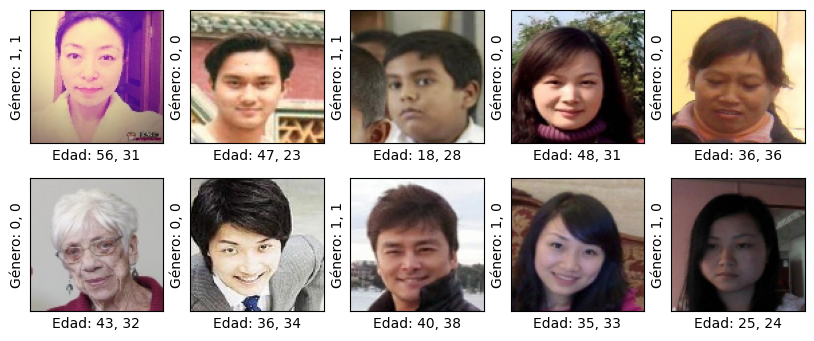

In [72]:
plt.figure(figsize=(10, 4))

for i in range(10):
    plt.subplot(2, 5, i+1)
    j = np.random.randint(len(y_age_val))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[j])
    plt.xlabel(f'Edad: {int(np.round(80*y_age_val[j]))}, {int(80*age_predictions[j])}')
    plt.ylabel(f'Género: {y_gender_val[j]}, {int(np.round(gender_predictions[j]))}')
plt.show()

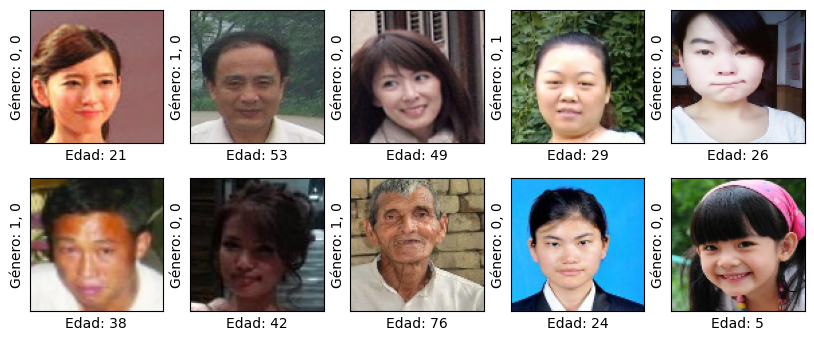

In [67]:
plt.figure(figsize=(10, 4))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i])
    plt.xlabel(f'Edad: {int(80*y_age[i])}')
    plt.ylabel(f'Género: {y_gender[i]}, {int(np.round(gender_predictions[i]))}')
plt.show()